https://stackoverflow.com/questions/63201036/add-additional-layers-to-the-huggingface-transformers

https://stackoverflow.com/questions/64156202/add-dense-layer-on-top-of-huggingface-bert-model

https://stackoverflow.com/questions/63201036/add-additional-layers-to-the-huggingface-transformers

https://stackoverflow.com/questions/51093691/custom-activation-function-keras-applying-different-activation-to-different-lay

In [ ]:
# Comprobamos si está tensorflow-gpu==2.3.0
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.22
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
dlib==19.18.0
dm-tree==0.1.6
docopt==0.6.2


In [ ]:
# Esta es la tarjeta grafica
!nvidia-smi

Wed May 12 10:52:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |   1090MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# instalar librerías. Esta casilla es últil por ejemplo si se ejecuta el cuaderno en Google Colab
# Note que existen otras dependencias como tensorflow, etc. que en este caso se encontrarían ya instaladas

%%capture
# Libreríía transformers
try:
    import tranformers
    print("module 'tranformers' is installed")
except ModuleNotFoundError:
    print("module 'transformers' is being installed")
    !pip install transformers==4.2.1
# Por si se quiere usar la gpu verificamos si tenemos transformers-gpu
import sys
if "tensorflow-gpu" in sys.modules:
    print("tensorflow-gpu already in sys.modules")
else: 
  !pip install tensorflow-gpu==2.3.0

In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertConfig, TFDistilBertModel, DistilBertTokenizer
from sklearn import preprocessing
from sklearn.metrics import f1_score
# Para trabajar teniendo encuenta el desbalanceo
from sklearn.utils import class_weight
import os
import tqdm
import numpy as np
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [ ]:
train_dataframe = pd.read_csv("https://raw.githubusercontent.com/jibt1/competition_group/main/datasets/haha_2021_train.csv", sep=',')
# According to https://www.fing.edu.uy/inco/grupos/pln/haha/
# we have to assume it is a joke so we can filter by humorous tweets
train_dataframe = train_dataframe.query('is_humor == 1')
train_dataframe.head(6)

,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,humor_rating,humor_mechanism,humor_target
0,tweet1,Niveles de retraso mental: \n\n— Bajo.\n— Medi...,1,1,2,2,0,0,0,1.50,NaN,NaN
1,tweet2,"—Vamos Luke desenfunda tu sable, demuestra tu ...",1,1,3,0,1,0,0,1.50,NaN,NaN
2,tweet3,"- ¿Te ofrezco algo?, ¿Agua, café, mi corazón, ...",1,0,2,1,0,1,1,2.60,NaN,NaN
6,tweet7,"—Buenas don Pepe, ¿me vende un litro de leche?...",1,1,1,1,1,1,0,2.50,NaN,NaN
12,tweet13,#20CosasQueHacerAntesDeMorir: Enseñarles la di...,1,0,1,1,2,1,0,2.60,reference,NaN
13,tweet14,Leí que la falta de sexo trae consigo una nota...,1,1,1,0,1,1,1,3.25,NaN,NaN


In [ ]:
x_train = train_dataframe['text']
y_train = train_dataframe['humor_rating']

In [ ]:
cfg = {}
cfg["framework"] = "tf"
cfg["max_length"] = 256 # 380 caracteros maximo por tweet (Mirar maximo de longitud)
cfg["transformer_model_name"] = "dccuchile/bert-base-spanish-wwm-cased" # Este es el modelo Bert para Spanish, con mayusculas
cfg["num_labels"] = 1

In [ ]:
# dim dimension del pooling layer de los outputs del encoder en la salida de la ultima capa
# https://huggingface.co/transformers/model_doc/distilbert.html
# https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased
# dropout es el dropout de las denses de las capas de encoders
# seq_classif_dropout es el dropout de la ultima densa ajena a Bert
# Reducimos la complejidad del problema, solo tenemos 25000 tweets

# cargar el tokenizador, disponible en Transformers
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'] )

# instanciar y entrenar LabelBinarizer
#cfg['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

config_bert = DistilBertConfig(attention_dropout=0.75, dropout=0.75,
                               n_heads=2, dim=32, max_position_embeddings=cfg["max_length"],
                               n_layers=2, hidden_dim=64, vocab_size=cfg['tokenizer'].vocab_size, output_hidden_states=True)
# model = TFDistilBertModel.from_pretrained(cfg["transformer_model_name"], config=config_bert)

In [ ]:
cfg['tokenizer'].vocab_size

31002

In [ ]:
# ML Keras
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, LeakyReLU, ReLU, Activation, Dropout, Conv1D, Reshape, Flatten, MaxPooling1D, Lambda, Concatenate
from tensorflow.keras.activations import softmax, tanh, sigmoid, gelu
from keras.utils import np_utils
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


In [ ]:
class CustomDistilBERTModel():
    def __init__(self, cfg, config_bert):

          # Configuraciones
          self.cgf = cfg
          self.config_bert = config_bert
          
          # Instanciamos DistilBertModel
          self.DistilBert = TFDistilBertModel.from_pretrained(self.cgf["transformer_model_name"],
                                                      config=self.config_bert)
          self.DistilBert_model = None

    def custom_activation(self, sigma):
      # https://stackoverflow.com/questions/51093691/custom-activation-function-keras-applying-different-activation-to-different-lay
      return 4*sigma+1

    """def custom_activation_shape(self, input_shape):
        # Ensure there is rank 4 tensor
        assert len(input_shape) == 4
        # Ensure the last input component has 5 dimensions
        assert input_shape[3] == 5

        return input_shape  # Shape is unchanged"""

    def get_model_inputs(self, cfg, data):
        encodings = cfg['tokenizer'](data, truncation=True, padding='max_length', max_length=cfg['max_length'], return_tensors=cfg['framework'])
        inputs = {'input_ids': encodings['input_ids'],
                'attention_mask': encodings['attention_mask']
                }
        return inputs

    def DistilBertNN(self):#, ids, mask):
          # https://stackoverflow.com/questions/64156202/add-dense-layer-on-top-of-huggingface-bert-model
          # https://stackoverflow.com/questions/63201036/add-additional-layers-to-the-huggingface-transformers
          input_ids = Input(shape=(256, ),dtype='int32')
          attention_mask = Input(shape=(256, ), dtype='int32')

          # https://huggingface.co/transformers/model_doc/distilbert.html#distilbertmodel

          output_bert = self.DistilBert(
                                    input_ids=input_ids, 
                                    attention_mask=attention_mask
                                    )
          """
          last_hidden_state, 1 tensor
          hidden_states, 3 tensores (n_layers = 2 + entrada)
          attention = None (en principio)
          """
          output_bert = output_bert['hidden_states']
          """
          (batch_size, longitud_secuencia, profundidad de las capas FF intermedias)
          (batch_size, max_position_embeddings, dim=32)
          """

          # Probar tambien sumando
          output_bert = Concatenate()(output_bert)
          dense = MaxPooling1D(pool_size=4)(output_bert)
          dense = Flatten()(dense)
          dense = Dense(128)(dense)
          dense = BatchNormalization()(dense)
          dense = LeakyReLU()(dense)
          dense = Dropout(0.4)(dense)
          dense = Dense(64)(dense)
          dense = BatchNormalization()(dense)
          dense = gelu(dense)
          dense = Dropout(0.2)(dense)

          dense = Dense(1)(dense)
          dense = BatchNormalization()(dense)
          dense = sigmoid(dense)
          output = Lambda(self.custom_activation, 
                          output_shape=(None,1))(dense)

          ### Output
          model = Model([input_ids, attention_mask], output)

          ### Cross Entropy y Optimizador Adam
          model.compile(optimizer="adam", loss="mse", metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
          model.summary()

          self.DistilBert_model = model

    def train_model(self, x_train, y_train):
        """
        Método que entrena el modelo.

        Args:

        * x_train: matriz de diseño
        * y_train: target codificada
        """

        """
        tokens + attention_mask
        """

        self.DistilBertNN()

        # Creo un conjunto de validación con data splitting
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                          test_size=.15)
        
        train_inputs = self.get_model_inputs(cfg, x_train.to_list())
        val_inputs = self.get_model_inputs(cfg, x_val.to_list())

        # obtener tensores correspondientes
        train_blabels_t = tf.convert_to_tensor(y_train, dtype='int32')
        val_blabels_t = tf.convert_to_tensor(y_val, dtype='int32')

        # Instancio el méétodo earlyStopping para no perseverar en el entrenamiento si
        # se obtiene una mejora tras una paciencia de 8 iteraciones
        """earlyStopping = EarlyStopping(monitor='val_accuracy', patience=8, verbose=0, mode='max')"""

        # Creo un guardado del mejor modelo visto hasta el fin del entrenamiento monitorizando
        # el val_accuracy
        """checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)"""

        # Ajusto el modelo con 50 epocas controladas por earlyStopiing y batch size de 50
        self.DistilBert_model.fit([train_inputs['input_ids'], train_inputs['attention_mask']], train_blabels_t, 
                  batch_size = 32, epochs = 10,
                  verbose = 1,
                  # callbacks=[earlyStopping, checkpoint],
                  validation_data=([val_inputs['input_ids'], val_inputs['attention_mask']], val_blabels_t))
        plt.hist(self.DistilBert_model.predict([train_inputs['input_ids'], train_inputs['attention_mask']]))

In [ ]:
instancia = CustomDistilBERTModel(cfg, config_bert)

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFDistilBertModel: ['mlm___cls', 'bert']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['distilbert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_89 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_90 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_45 (TFDist TFBaseModelOutput(la 1017408     input_89[0][0]                   
                                                                 input_90[0][0]                   
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 256, 96)      0           tf_distil_bert_model_45[0]

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/10


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


244/246 [============================>.] - ETA: 0s - loss: 2.6245 - mae: 1.3641 - root_mean_squared_error: 1.6195

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


246/246 [==============================] - 10s 26ms/step - loss: 2.6218 - mae: 1.3632 - root_mean_squared_error: 1.6187 - val_loss: 1.9709 - val_mae: 1.2247 - val_root_mean_squared_error: 1.4039
Epoch 2/10
246/246 [==============================] - 5s 20ms/step - loss: 1.8257 - mae: 1.1174 - root_mean_squared_error: 1.3510 - val_loss: 1.1168 - val_mae: 0.9035 - val_root_mean_squared_error: 1.0568
Epoch 3/10
246/246 [==============================] - 5s 19ms/step - loss: 1.3248 - mae: 0.9550 - root_mean_squared_error: 1.1505 - val_loss: 1.6580 - val_mae: 1.0889 - val_root_mean_squared_error: 1.2876
Epoch 4/10
246/246 [==============================] - 5s 19ms/step - loss: 0.8616 - mae: 0.7812 - root_mean_squared_error: 0.9281 - val_loss: 1.2182 - val_mae: 0.9602 - val_root_mean_squared_error: 1.1037
Epoch 5/10
246/246 [==============================] - 5s 19ms/step - loss: 0.6500 - mae: 0.6726 - root_mean_squared_error: 0.8060 - val_loss: 0.8746 - val_mae: 0.7944 - val_root_mean_squared

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


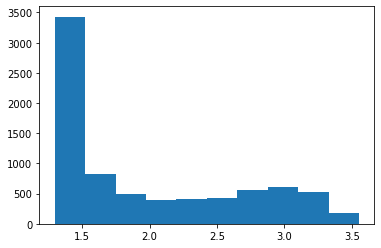

In [ ]:
instancia.train_model(x_train, y_train)

---

---

---

In [ ]:
# Tripadvisor, aplicamos regresion sin reducir de 5 puntos a 0 1 2
# Cambiar las metricas, MSE

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1Score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)
model.compile(optimizer=optimizer, loss=loss, metrics = [f1Score, 'accuracy'])
model.summary()

In [ ]:
# Cargamos el tokenizador correspondiente ¿Lematiza?
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'] )
# Proceso de scikit learn para hacer OHE a 0 1 de la salida
cfg['label_binarizer'] = preprocessing.LabelBinarizer()

In [ ]:
# Empleamos el labelizador
cfg['label_binarizer'].fit(train_dataframe["is_humor"])
train_blabels = cfg['label_binarizer'].transform(train_dataframe["is_humor"])
print(train_blabels)
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')

# Clases ligeramente desbalanceadas
df_clases = pd.DataFrame(train_blabels)
round(df_clases.value_counts()/df_clases.shape[0] * 100, 2)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [1]]


0    61.45
1    38.55
dtype: float64

In [ ]:
def get_model_inputs(cfg, data):
    encodings = cfg['tokenizer'](data, truncation=True, padding='max_length', max_length=cfg['max_length'], return_tensors=cfg['framework'])
    inputs = {'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
            }
    return inputs

In [ ]:
# Constriumos la matriz de diseño con sus correspondientes Masks
train_inputs = get_model_inputs(cfg, train_dataframe["text"].to_list())
train_inputs

{'attention_mask': <tf.Tensor: shape=(24000, 256), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_ids': <tf.Tensor: shape=(24000, 256), dtype=int32, numpy=
 array([[    4, 10682,  1019, ...,     1,     1,     1],
        [    4,     3,  1716, ...,     1,     1,     1],
        [    4,  1149,  1067, ...,     1,     1,     1],
        ...,
        [    4,  2448,  1030, ...,     1,     1,     1],
        [    4,  4596,  1512, ...,     1,     1,     1],
        [    4,  1153,  8386, ...,     1,     1,     1]], dtype=int32)>}

In [ ]:
print(cfg['tokenizer'].pad_token)
cfg['tokenizer'].encode([cfg['tokenizer'].pad_token])

[PAD]


[4, 1, 5]

In [ ]:
cfg['tokenizer'].decode([4, 1, 5])

'[CLS] [PAD] [SEP]'

In [ ]:
cfg['checkpoints_dir'] = 'checkpoints'
cfg['model_name'] = 'distilbert-humor'
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

In [ ]:
tlabels = train_blabels.reshape(train_blabels.shape[0])

In [ ]:
train_inputs

{'attention_mask': <tf.Tensor: shape=(24000, 256), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_ids': <tf.Tensor: shape=(24000, 256), dtype=int32, numpy=
 array([[    4, 10682,  1019, ...,     1,     1,     1],
        [    4,     3,  1716, ...,     1,     1,     1],
        [    4,  1149,  1067, ...,     1,     1,     1],
        ...,
        [    4,  2448,  1030, ...,     1,     1,     1],
        [    4,  4596,  1512, ...,     1,     1,     1],
        [    4,  1153,  8386, ...,     1,     1,     1]], dtype=int32)>}

In [ ]:
epochs_max = 30
epochs_to_save = 5
batch_size = 32

class_weights = class_weight.compute_class_weight('balanced', np.unique(tlabels), tlabels)
class_weights = dict(enumerate(class_weights))

for epoch in tqdm.tqdm(range(0, epochs_max, epochs_to_save)):
    print(f'Training model, epochs {epoch+1} - {epoch+epochs_to_save}')
    
    # entrenar el modelo. Opcionalmente, se puede suministrar datos de validación => validation_data=(val_inputs,val_blabels_t )
    model.fit(train_inputs, y=train_blabels_t, epochs=epochs_to_save, batch_size=batch_size,
              validation_split=0.25, class_weight=class_weights)

    model.save_pretrained(cfg['trained_model_name'] + f'-epochs-{epoch+1:03d}-{epoch+epochs_to_save:03d}')
    cfg['tokenizer'].save_pretrained(cfg['trained_model_name'] + f'-epochs-{epoch+1:03d}-{epoch+epochs_to_save:03d}')


  0%|          | 0/6 [00:00<?, ?it/s]The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Training model, epochs 1 - 5
Epoch 1/5


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


562/563 [============================>.] - ETA: 0s - loss: 0.6768 - f1Score: 0.0000e+00 - accuracy: 0.6615

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


563/563 [==============================] - 5s 10ms/step - loss: 0.6769 - f1Score: 0.0000e+00 - accuracy: 0.6614 - val_loss: 0.6940 - val_f1Score: 0.0000e+00 - val_accuracy: 0.4737
Epoch 2/5
563/563 [==============================] - 5s 9ms/step - loss: 0.6756 - f1Score: 0.0000e+00 - accuracy: 0.6614 - val_loss: 0.6955 - val_f1Score: 0.0000e+00 - val_accuracy: 0.4737
Epoch 3/5
563/563 [==============================] - 5s 9ms/step - loss: 0.6714 - f1Score: 0.0000e+00 - accuracy: 0.6614 - val_loss: 0.6856 - val_f1Score: 0.0000e+00 - val_accuracy: 0.4737
Epoch 4/5
563/563 [==============================] - 5s 9ms/step - loss: 0.6433 - f1Score: 0.0000e+00 - accuracy: 0.6614 - val_loss: 0.6498 - val_f1Score: 0.0000e+00 - val_accuracy: 0.4737
Epoch 5/5
563/563 [==============================] - 5s 9ms/step - loss: 0.6011 - f1Score: 0.0000e+00 - accuracy: 0.6614 - val_loss: 0.6145 - val_f1Score: 0.0000e+00 - val_accuracy: 0.4737



 17%|█▋        | 1/6 [00:27<02:18, 27.76s/it]

Training model, epochs 6 - 10
Epoch 1/5
563/563 [==============================] - 5s 9ms/step - loss: 0.5613 - f1Score: 0.2043 - accuracy: 0.6913 - val_loss: 0.5867 - val_f1Score: 0.6174 - val_accuracy: 0.6935
Epoch 2/5
563/563 [==============================] - 5s 9ms/step - loss: 0.5309 - f1Score: 0.5038 - accuracy: 0.7434 - val_loss: 0.5632 - val_f1Score: 0.7190 - val_accuracy: 0.7402
Epoch 3/5
563/563 [==============================] - 5s 9ms/step - loss: 0.5045 - f1Score: 0.6373 - accuracy: 0.7830 - val_loss: 0.5423 - val_f1Score: 0.7325 - val_accuracy: 0.7542
Epoch 4/5
563/563 [==============================] - 5s 9ms/step - loss: 0.4851 - f1Score: 0.6566 - accuracy: 0.7892 - val_loss: 0.5313 - val_f1Score: 0.7291 - val_accuracy: 0.7572
Epoch 5/5
563/563 [==============================] - 5s 9ms/step - loss: 0.4672 - f1Score: 0.6714 - accuracy: 0.7967 - val_loss: 0.5173 - val_f1Score: 0.7432 - val_accuracy: 0.7670



 33%|███▎      | 2/6 [00:53<01:48, 27.09s/it]

Training model, epochs 11 - 15
Epoch 1/5
563/563 [==============================] - 5s 9ms/step - loss: 0.4514 - f1Score: 0.7006 - accuracy: 0.8131 - val_loss: 0.5070 - val_f1Score: 0.7540 - val_accuracy: 0.7733
Epoch 2/5
563/563 [==============================] - 5s 9ms/step - loss: 0.4434 - f1Score: 0.7126 - accuracy: 0.8153 - val_loss: 0.5014 - val_f1Score: 0.7606 - val_accuracy: 0.7752
Epoch 3/5
563/563 [==============================] - 5s 9ms/step - loss: 0.4333 - f1Score: 0.7254 - accuracy: 0.8234 - val_loss: 0.4978 - val_f1Score: 0.7572 - val_accuracy: 0.7767
Epoch 4/5
563/563 [==============================] - 5s 9ms/step - loss: 0.4245 - f1Score: 0.7338 - accuracy: 0.8280 - val_loss: 0.4958 - val_f1Score: 0.7641 - val_accuracy: 0.7788
Epoch 5/5
563/563 [==============================] - 5s 9ms/step - loss: 0.4185 - f1Score: 0.7386 - accuracy: 0.8321 - val_loss: 0.4902 - val_f1Score: 0.7631 - val_accuracy: 0.7798



 50%|█████     | 3/6 [01:18<01:19, 26.58s/it]

Training model, epochs 16 - 20
Epoch 1/5
563/563 [==============================] - 5s 9ms/step - loss: 0.4123 - f1Score: 0.7462 - accuracy: 0.8366 - val_loss: 0.4860 - val_f1Score: 0.7642 - val_accuracy: 0.7788
Epoch 2/5
563/563 [==============================] - 5s 9ms/step - loss: 0.4031 - f1Score: 0.7468 - accuracy: 0.8398 - val_loss: 0.4871 - val_f1Score: 0.7666 - val_accuracy: 0.7813
Epoch 3/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3957 - f1Score: 0.7541 - accuracy: 0.8429 - val_loss: 0.4914 - val_f1Score: 0.7595 - val_accuracy: 0.7783
Epoch 4/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3898 - f1Score: 0.7651 - accuracy: 0.8486 - val_loss: 0.4859 - val_f1Score: 0.7607 - val_accuracy: 0.7778
Epoch 5/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3821 - f1Score: 0.7635 - accuracy: 0.8488 - val_loss: 0.4839 - val_f1Score: 0.7644 - val_accuracy: 0.7802



 67%|██████▋   | 4/6 [01:44<00:52, 26.28s/it]

Training model, epochs 21 - 25
Epoch 1/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3784 - f1Score: 0.7661 - accuracy: 0.8511 - val_loss: 0.4852 - val_f1Score: 0.7611 - val_accuracy: 0.7795
Epoch 2/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3764 - f1Score: 0.7698 - accuracy: 0.8521 - val_loss: 0.4872 - val_f1Score: 0.7582 - val_accuracy: 0.7790
Epoch 3/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3670 - f1Score: 0.7763 - accuracy: 0.8572 - val_loss: 0.4868 - val_f1Score: 0.7654 - val_accuracy: 0.7802
Epoch 4/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3663 - f1Score: 0.7803 - accuracy: 0.8591 - val_loss: 0.4921 - val_f1Score: 0.7584 - val_accuracy: 0.7787
Epoch 5/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3609 - f1Score: 0.7760 - accuracy: 0.8573 - val_loss: 0.4891 - val_f1Score: 0.7674 - val_accuracy: 0.7820



 83%|████████▎ | 5/6 [02:09<00:25, 25.96s/it]

Training model, epochs 26 - 30
Epoch 1/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3573 - f1Score: 0.7838 - accuracy: 0.8620 - val_loss: 0.4895 - val_f1Score: 0.7691 - val_accuracy: 0.7837
Epoch 2/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3528 - f1Score: 0.7911 - accuracy: 0.8647 - val_loss: 0.4951 - val_f1Score: 0.7584 - val_accuracy: 0.7793
Epoch 3/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3501 - f1Score: 0.7898 - accuracy: 0.8652 - val_loss: 0.4921 - val_f1Score: 0.7647 - val_accuracy: 0.7830
Epoch 4/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3508 - f1Score: 0.7900 - accuracy: 0.8649 - val_loss: 0.4955 - val_f1Score: 0.7607 - val_accuracy: 0.7817
Epoch 5/5
563/563 [==============================] - 5s 9ms/step - loss: 0.3445 - f1Score: 0.7924 - accuracy: 0.8671 - val_loss: 0.4902 - val_f1Score: 0.7669 - val_accuracy: 0.7860



100%|██████████| 6/6 [02:34<00:00, 25.83s/it]


# Regresion

In [ ]:
from transformers import BertModel
class CustomBERTModel(nn.Module):
    def __init__(self):
          super(CustomBERTModel, self).__init__()
          self.bert = BertModel.from_pretrained("dbmdz/bert-base-italian-xxl-cased")
          ### New layers:
          self.linear1 = nn.Linear(768, 256)
          self.linear2 = nn.Linear(256, 3) ## 3 is the number of classes in this example

    def forward(self, ids, mask):
          sequence_output, pooled_output = self.bert(
               ids, 
               attention_mask=mask)

          # sequence_output has the following shape: (batch_size, sequence_length, 768)
          linear1_output = self.linear1(sequence_output[:,0,:].view(-1,768)) ## extract the 1st token's embeddings

          linear2_output = self.linear2(linear2_output)

          return linear2_output

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-xxl-cased")
model = CustomBERTModel() # You can pass the parameters if required to have more flexible model
model.to(torch.device("cpu")) ## can be gpu
criterion = nn.CrossEntropyLoss() ## If required define your own criterion
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

for epoch in epochs:
    for batch in data_loader: ## If you have a DataLoader()  object to get the data.

        data = batch[0]
        targets = batch[1] ## assuming that data loader returns a tuple of data and its targets
        
        optimizer.zero_grad()   
        encoding = tokenizer.batch_encode_plus(data, return_tensors='pt', padding=True, truncation=True,max_length=50, add_special_tokens = True)
        outputs = model(input_ids, attention_mask=attention_mask)
        outputs = F.log_softmax(outputs, dim=1)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()